In [2]:
!pip install gdown
!gdown --id 1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn
!gdown --id 1uiL-O3EtAholf9qrtR8TlppjrGHW10Rh

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn
From (redirected): https://drive.google.com/uc?id=1-1EjRHAq-4nhXIJ9-OobWmMXavl1B4zn&confirm=t&uuid=765aed44-289b-4ea4-a7df-300d485044b7
To: /kaggle/working/data.pkl
100%|███████████████████████████████████████| 1.24G/1.24G [00:07<00:00, 163MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uiL-O3EtAholf9qrtR8TlppjrGHW10Rh
To: /kaggle/working/3DECGNet.h5
100%|███████████████████████████████████████| 3.57M/3.57M [00:00<00:00, 249MB/s]


In [3]:
import pickle
from tqdm import tqdm
import tensorflow as tf
import numpy as np

from preprocess import data_preparation
from preprocess import signal_cutter
from preprocess import data_filtering
from preprocess import resampling
from preprocess import RP_3D
from preprocess import resize_volume
from preprocess import RP_final_data
from preprocess import label_creator
from preprocess import including_data
from lime_utils import tp_finder
from lime_utils import lead_replacing
from lime_utils import weight_bars

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Read dictionary pkl file
with open('/kaggle/working/data.pkl', 'rb') as fp:
    dataset = pickle.load(fp)

In [5]:
ds = data_preparation(dataset)

# shortening
ds = signal_cutter(ds, d_length=1000)

# denoising
ds = data_filtering(ds)

# resampling
ds = resampling(ds, desired_points = 100)

100%|██████████| 10344/10344 [00:01<00:00, 8038.81it/s]


In [6]:
arr = {'NSR':'426783006', 'AF':'164889003', 'IAVB':'270492004', 'LBBB':'164909002', 'RBBB':'59118001', 'SB':'426177001', 'STach':'427084000'}
labels = label_creator(data_preparation(dataset), arr)
x_train, y_train, x_test, y_test = including_data(labels, ds)
# transformation and resizing
tmp_x_test = RP_final_data(x_test)

100%|██████████| 10344/10344 [00:00<00:00, 949051.31it/s]
10344it [00:07, 1347.41it/s]
10344it [00:04, 2136.90it/s]
100%|██████████| 1126/1126 [05:34<00:00,  3.37it/s]


In [7]:
model = tf.keras.models.load_model('/kaggle/working/3DECGNet.h5')
pred_proba = model.predict(tmp_x_test)
prediction = np.zeros(np.shape(pred_proba))
prediction[pred_proba > 0.5] = 1

36/36 [==============================] - 15s 338ms/step


In [8]:
neigh_mx = lead_replacing()

# !!!!!!Change arrhythmia
tp_samples = tp_finder(prediction, y_test, 'SB', arr)

In [9]:
len(tp_samples)

252

In [30]:
from sklearn.linear_model import LogisticRegression
cof = []
counter = 101

for i in tp_samples[100:149]:
    print('sample numbet', counter)
    counter = counter + 1
    neighbors = []
    for j in neigh_mx:
        neighbors.append(j * x_test[i])
    neighbor_tr = RP_final_data(neighbors)
    p = model.predict(neighbor_tr)
    pp = np.zeros(np.shape(p))
    pp[p > 0.5] = 1
    wei = []
    for k in np.squeeze(neigh_mx):
        wei.append(sum(k)/12)
    lr = LogisticRegression()
    
    # !!!!!!Change arrhythmia
    lr.fit(np.squeeze(neigh_mx), pp[:,5], sample_weight = wei)
    
    cof.append(lr.coef_)

sample numbet 101


100%|██████████| 793/793 [03:54<00:00,  3.38it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 102


100%|██████████| 793/793 [03:54<00:00,  3.38it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 103


100%|██████████| 793/793 [03:54<00:00,  3.38it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 104


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 105


100%|██████████| 793/793 [03:54<00:00,  3.38it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 106


100%|██████████| 793/793 [03:54<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 107


100%|██████████| 793/793 [03:54<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 108


100%|██████████| 793/793 [03:54<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 109


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 110


100%|██████████| 793/793 [03:54<00:00,  3.38it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 111


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 112


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 113


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 114


100%|██████████| 793/793 [03:53<00:00,  3.39it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 115


100%|██████████| 793/793 [03:54<00:00,  3.38it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 116


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 117


100%|██████████| 793/793 [03:57<00:00,  3.33it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 118


100%|██████████| 793/793 [03:57<00:00,  3.34it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 119


100%|██████████| 793/793 [03:57<00:00,  3.34it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 120


100%|██████████| 793/793 [03:57<00:00,  3.34it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 121


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 122


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 123


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 124


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 125


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 126


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 127


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 128


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 129


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 130


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 131


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 132


100%|██████████| 793/793 [04:00<00:00,  3.30it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 133


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 134


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 135


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 136


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 137


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 138


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 139


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 140


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 141


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 142


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 143


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 144


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 145


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 146


100%|██████████| 793/793 [03:56<00:00,  3.35it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 147


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 337ms/step
sample numbet 148


100%|██████████| 793/793 [03:56<00:00,  3.36it/s]


25/25 [==============================] - 8s 338ms/step
sample numbet 149


100%|██████████| 793/793 [03:55<00:00,  3.37it/s]


25/25 [==============================] - 8s 337ms/step


In [31]:
cf2 = np.squeeze(cof)

In [32]:
my_dict = {
    'Lead I':cf2[:,0],
    'Lead II':cf2[:,1],
    'Lead III':cf2[:,2],
    'Lead avF':cf2[:,3],
    'Lead avR':cf2[:,4],
    'Lead avL':cf2[:,5],
    'Lead V1':cf2[:,6],
    'Lead V2':cf2[:,7],
    'Lead V3':cf2[:,8],
    'Lead V4':cf2[:,9],
    'Lead V5':cf2[:,10],
    'Lead V6':cf2[:,11]
}

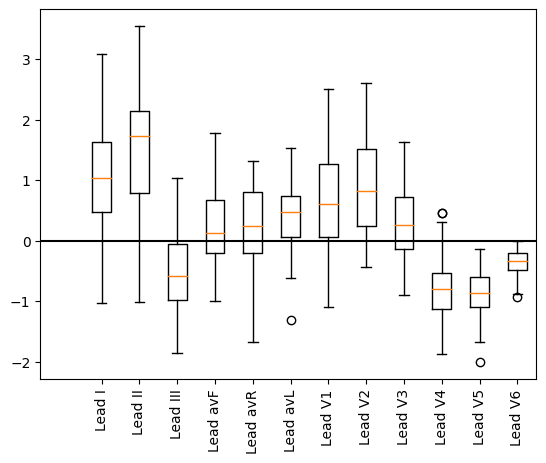

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
plt.axline((0,0),(11,0),color='black')
ax.set_xticklabels(my_dict.keys())
plt.xticks(rotation=90)
plt.show()

In [34]:
np.savez('/kaggle/working/SBweights_1' , cf2)